In [71]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_stata('./cyobero/datasets/stockton2.dta')
df.head()

,price,sqft,beds,baths,age,stories,vacant
0,205000.0,2377.0,4.0,3.0,0.0,2.0,1.0
1,230000.0,2325.0,4.0,3.0,0.0,2.0,1.0
2,117000.0,1651.0,3.0,2.0,9.0,2.0,1.0
3,80000.0,1213.0,3.0,1.0,63.0,1.0,0.0
4,116500.0,1800.0,4.0,2.0,17.0,1.0,0.0


In [3]:
# get summary statistics
df.describe()

,price,sqft,beds,baths,age,stories,vacant
count,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000
mean,112810.812500,1611.968140,3.170455,2.054545,24.557955,1.206818,0.528409
std,52813.886719,531.990173,0.691597,0.667277,20.649164,0.405254,0.499476
min,50000.000000,704.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,79900.000000,1200.750000,3.000000,2.000000,8.000000,1.000000,0.000000
50%,99950.000000,1516.000000,3.000000,2.000000,18.000000,1.000000,1.000000
75%,128000.000000,1874.000000,4.000000,2.000000,38.000000,1.000000,1.000000
max,500000.000000,4300.000000,6.000000,5.000000,96.000000,2.000000,1.000000


correlation matrix

In [4]:
df.corr()

,price,sqft,beds,baths,age,stories,vacant
price,1.000000,0.819825,0.420408,0.595668,-0.238426,0.393688,-0.202228
sqft,0.819825,1.000000,0.659254,0.752740,-0.206888,0.570908,-0.147236
beds,0.420408,0.659254,1.000000,0.647899,-0.306199,0.531650,-0.079902
baths,0.595668,0.752740,0.647899,1.000000,-0.423960,0.639777,-0.045616
age,-0.238426,-0.206888,-0.306199,-0.423960,1.000000,-0.113049,-0.102964
stories,0.393688,0.570908,0.531650,0.639777,-0.113049,1.000000,-0.029060
vacant,-0.202228,-0.147236,-0.079902,-0.045616,-0.102964,-0.029060,1.000000


Square footage ("sqft") is highly correlated with price ($\rho=0.82$). 
Sqft also seems to be serially correlated with beds and baths. We might take this into consideration when building our model.

### Pairwise Scatterplot

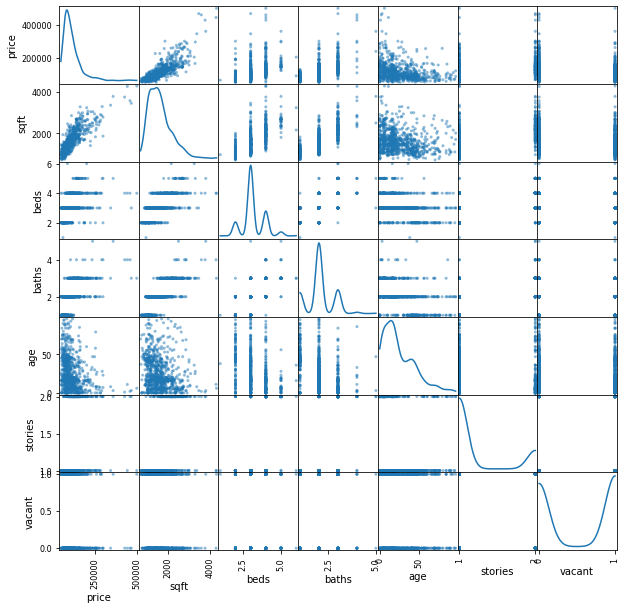

In [11]:
pd.plotting.scatter_matrix(df, alpha=0.5, figsize=(10,10), diagonal='kde')
plt.show()

Price also looks like it's negatively correlated with age. 

Create a scatterplot of price vs sqft and price vs age.

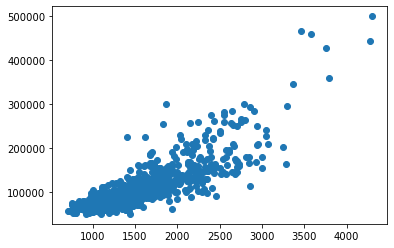

In [13]:
plt.scatter(df['sqft'], df['price'])
plt.show()

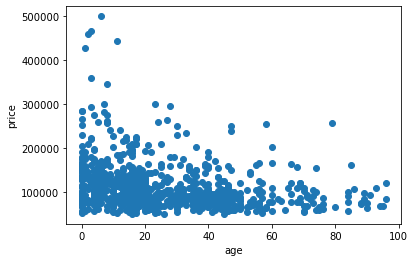

In [15]:
plt.scatter(df['age'], df['price'])
plt.xlabel('age')
plt.ylabel('price')
plt.show()

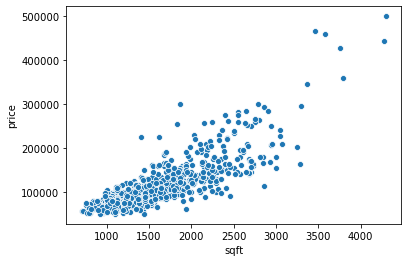

In [17]:
sns.scatterplot(df['sqft'], df['price'])
plt.show()

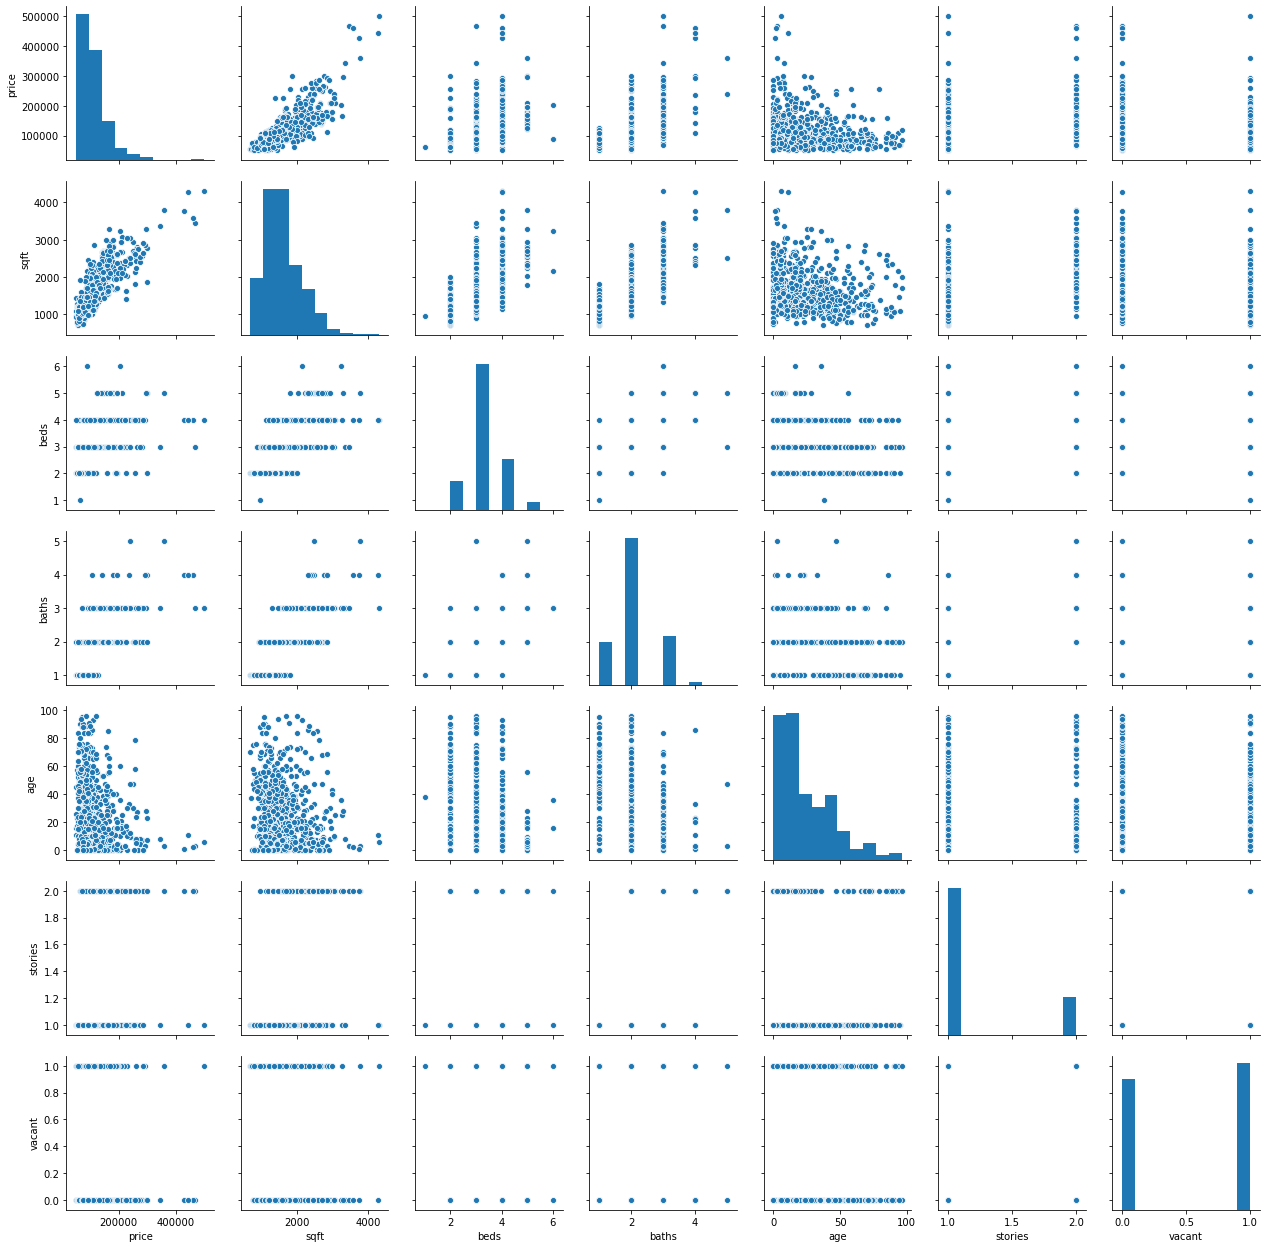

In [19]:
sns.pairplot(df)
plt.show()

### Correlation Matrix

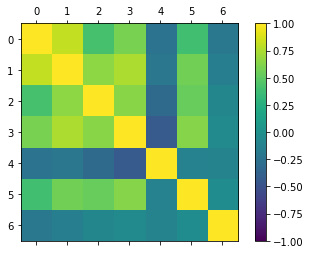

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
my_plt = ax.matshow(df.corr(), vmin=-1, vmax=1)
fig.colorbar(my_plt)
plt.show()

Vacancy (1 if vacant, 0 if not vacant) looks negatively correlated with price. Let's create some graphs comparing price of vacant homes vs price of non-vacant homes.

### Barplot

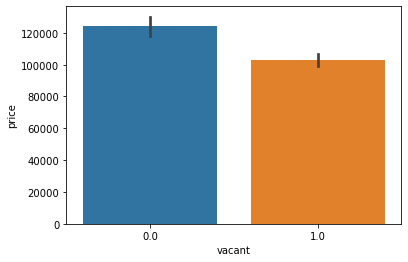

In [25]:
sns.barplot(df['vacant'], df['price'])
plt.show()

In [33]:
mean_price_vacant = np.mean(df['price'].where(df['vacant']==1))
mean_price_occupied = np.mean(df['price'].where(df['vacant']==0))

In [34]:
mean_price_vacant

102726.625

In [35]:
mean_price_occupied

124109.95

### Boxplot

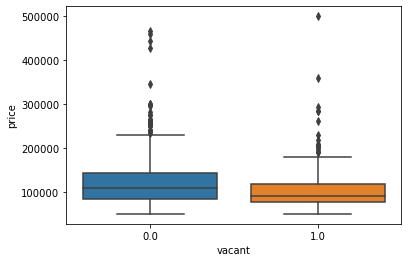

In [41]:
sns.boxplot(x=df['vacant'], y=df['price'])
plt.show()

### Histograms / Density Plots

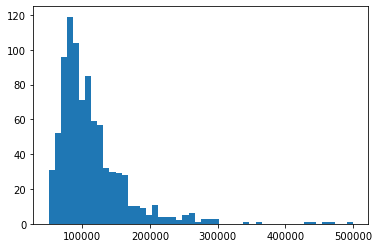

In [42]:
# histogram of price
plt.hist(df['price'], bins=50)
plt.show()

Price looks skewed to the right. Let's take the natural log $\ln{\text{price}}$ to see if we can get it to resemble a normal distribution. 

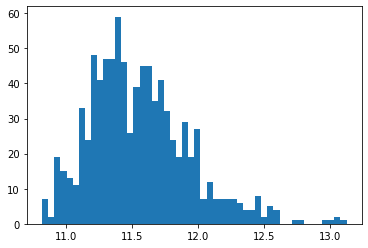

In [44]:
plt.hist(np.log(df['price']), bins=50)
plt.show()

Looks slightly better. 

## Fitting Our Model

Based on our quick EDA, let's try the following model:

$$
\begin{aligned}
\ln{\text{price}} = \beta_{0} + \beta_{1}\text{sqft} + \beta_{2}\text{age} + \beta_{3}\text{vacant} + e
\end{aligned}
$$

In [45]:
# split our model to train and test sets
X = df[['sqft', 'age', 'vacant']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [48]:
model = LinearRegression()
fit = model.fit(X_train, np.log(y_train))

In [55]:
fit.intercept_

10.755061

In [54]:
import statsmodels.api as sm

results = sm.OLS(np.log(y_train), X_train).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              3893.
Date:                Sun, 24 Nov 2019   Prob (F-statistic):                        0.00
Time:                        02:01:08   Log-Likelihood:                         -1584.2
No. Observations:                 660   AIC:                                      3174.
Df Residuals:                     657   BIC:                                      3188.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Our training model looks pretty good with an $R^{2}$ of $94.5 \%$. The t-values for our coefficients also are statistically significant at the $95 \%$ confidence level. 

**NOTE:** Be careful how we interpret our model since we log-transformed price. When computing our MSE, we will need to make sure to take the anti-log of both sides of our estimated regression model. In other words, our estimated model 

$$
\begin{aligned}
\ln{\widehat{\text{price}}} = 10.755 + 0.005\widehat{\text{sqft}} + 0.0653\widehat{\text{age}} + 2.3\widehat{\text{vacant}} 
\end{aligned}
$$

needs to become

$$
\begin{aligned}
\widehat{\text{price}} = \exp{[10.755 + 0.005\widehat{\text{sqft}} + 0.0653\widehat{\text{age}} + 2.3\widehat{\text{vacant}]}}
\end{aligned}
$$

In [74]:
# let's make some predictions on our test data
y_hat = fit.predict(X_test)

In [76]:
# get our residuals
resi = np.log(y_test) - y_hat
resi

220   -0.150154
1      0.388412
313    0.036190
311   -0.149535
168    0.064261
         ...   
707   -0.284477
121    0.101110
108   -0.012718
818   -0.187728
125   -0.079433
Name: price, Length: 220, dtype: float32

In [80]:
# mean squared error (MSE)
mse = mean_squared_error(np.log(y_test), y_hat)
mse

0.03791601

In [81]:
# variance of the error term
resi_var = np.var(resi)
resi_var

0.037813995

In [82]:
# bias^2 
bias_squared = np.mean(resi)**2
bias_squared

0.00010201525968178693

Let's plot our residuals $\hat{e}_{i}$ against $\hat{y}_{i}$.

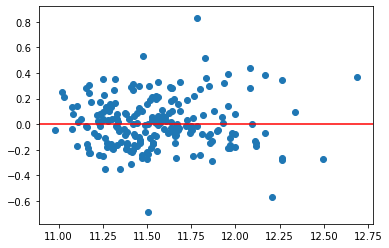

In [92]:
plt.scatter(y_hat, resi)
plt.axhline(y=0, color='r')
plt.show()

There doesn't seem to be any pattern in our residual plot, which suggests that there is little evidence of overfit/underfit.

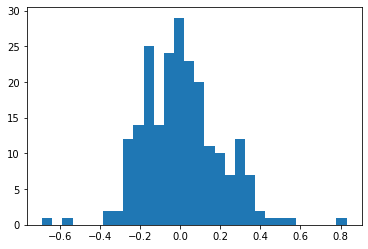

In [103]:
# distributionn of our residuals
plt.hist(resi, bins=30)
plt.show()